# Coeficientes de difracción, refracción y asomeramiento

En este notebook se van a calcular los coeficientes de difracción, refracción y asomeramiento en la parte que alberga un dique.

## Importamos las librerías necesarias

In [1]:
# import maths
import numpy as np
import xarray as xr
from sympy import *
import waves

# import matplotlib
import matplotlib
matplotlib.rcParams['animation.embed_limit'] = 2**32
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
plt.style.use('dark_background')
import plotly.graph_objects as go
from IPython.display import HTML # diplay anim

## definimos las ecuaciones / variables

In [2]:
# load all the symbols
k, r, pi, alpha, theta, h, g, T = symbols('k r pi alpha theta h g T')
lambdaa = symbols('lambda')

# we first define the K_d function
K_d = Function('K_d')(k,r,alpha,theta)
# but also other important functions
C = Function('C')(lambdaa)
C = integrate(cos(pi*lambdaa**2/2),(lambdaa,0,lambdaa))
S = Function('S')(lambdaa)
S = integrate(sin(pi*lambdaa**2/2),(lambdaa,0,lambdaa))
I_l = Function('I')(lambdaa)
I_l = (1+C+S)/2 + I*(C-S)/2

In [3]:
K_d

K_d(k, r, alpha, theta)

In [4]:
I_l

I*(sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 + sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4))

In [5]:
C

sqrt(pi)*fresnelc(lambda*sqrt(pi)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4))

In [6]:
S

3*sqrt(pi)*fresnels(lambda*sqrt(pi)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4))

In [7]:
K_d = abs(I_l.subs(lambdaa,-sqrt(4*k*r/pi)*sin((alpha-theta)/2))*exp(-I*k*r*cos(alpha-theta)) + \
          I_l.subs(lambdaa,-sqrt(4*k*r/pi)*sin((alpha+theta)/2))*exp(-I*k*r*cos(alpha+theta)))

In [8]:
K_d

Abs((I*(-sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 - sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 - theta/2)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4)))*exp(-I*k*r*cos(alpha - theta)) + (I*(-sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(1/4)/(4*sqrt(pi)*gamma(5/4)) + 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(3/4)/(4*sqrt(pi)*gamma(7/4)))/2 + 1/2 - sqrt(pi)*fresnelc(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(1/4)/(8*sqrt(pi)*gamma(5/4)) - 3*sqrt(pi)*fresnels(2*sqrt(pi)*sqrt(k*r/pi)*sin(alpha/2 + theta/2)/sqrt(pi))*gamma(3/4)/(8*sqrt(pi)*gamma(7/4)))*exp(-I*k*r*cos(alpha + theta)))

In [9]:
# definimos también kr y ks
K_s = sqrt((2*cosh(k*h)**2)/(2*k*h+sinh(2*k*h)**2))
K_r = sqrt(cos(np.pi/2/theta))
K = K_r * K_s

In [10]:
K

sqrt(2)*sqrt(cosh(h*k)**2/(2*h*k + sinh(2*h*k)**2))*sqrt(cos(1.5707963267949/theta))

In [11]:
KrKs = ((1-sin(theta)**2*tanh(k*h)**2)/cos(theta)**2)*(16*np.pi**2*h/g*T**2)**(-1/4)

In [12]:
KrKs

0.282094791773878*(T**2*h/g)**(-0.25)*(-sin(theta)**2*tanh(h*k)**2 + 1)/cos(theta)**2

## definir coordenadas y parámetros

In [13]:
# define polar coordinates
from sympy.abc import x, y
r = sqrt(x**2+y**2) # these are the polar coordinates
alpha = np.pi/2 - atan(x/y)

In [14]:
# fixed parameters for the wave
g_value = 9.8 # m / s^2
T_value = 8 # seconds
w_value = 2*np.pi/T_value
h_value = 5 # depth (meters)
# derived parameters for the wave
G_value = w_value**2*h_value/g_value
k_value = waves.Waves(h_value,T=T_value).k # wave number
# k_value = sqrt(w_value**2/g_value*h_value)
l_value = 2*np.pi/k_value
c_value = w_value/k_value
cg_value = c_value * 0.5 * (1 + 2*k_value*h_value/sinh(2*k_value*h_value))
H_value = 5 # wave height
# fixed parameters for the plot
dx = 10
x0 = 150
y0 = 350

In [15]:
# get diffraction/refraction/asomer coefficients for (x,y)
dirs = np.arange(1,85.1,5)
k_d = np.zeros((len(dirs),len(np.arange(0,x0,dx))))
k_s = np.zeros((len(dirs),len(np.arange(0,x0,dx))))
k_r = np.zeros((len(dirs),len(np.arange(0,x0,dx))))
k_rs = np.zeros((len(dirs),len(np.arange(0,x0,dx))))
h_values_mat = np.copy(k_d*k_s*k_r)
y_values = np.zeros((len(dirs),len(np.arange(0,x0,dx))))

for j,tj in enumerate(dirs):
    
    tj = tj*np.pi/180
    ys = 0
    
    for i,xs in enumerate(np.arange(1,x0,dx)):
            
        h_values = h_value - 0.03*xs
        
        G_values = (w_value**2)*h_values/g_value
        #k_values = sqrt((w_value**2)/(g_value*(h_value-0.02*xs))) # wave number
        k_values = waves.Waves(h_values,T=T_value).k
        c_values = w_value/k_values
        ys = ys + tan(asin(c_values/c_value*sin(tj)))*dx
        y_values[j,i] = abs(ys)
        cg_values = c_values * 0.5 * (1 + 2*k_values*h_values/sinh(2*k_values*h_values))
        tjs = asin(c_values/c_value*sin(tj))/tj
        
        print(f'Calculating K_d*K_s*K_r in ({xs},{abs(ys)}) -- in meters', end='\r')

        k_d[j,i] = float(
            K_d.evalf(subs={
                'k':k_values,'theta':np.pi/2,'pi':np.pi,
                'r':r.evalf(subs={'x':-ys,'y':xs}),
                'alpha':alpha.evalf(subs={'x':-ys,'y':xs})
            })
        )
        k_s[j,i] = float(
            (cg_value/cg_values)**0.5
        )
        k_r[j,i] = float(
            (cos(tj)/cos(abs(tjs)))**0.5
        )
        k_rs[j,i] = float(
            lambdify((theta),KrKs.evalf(subs={
                'h':h_values,'k':k_values,'T':T_value,
                'g':g_value}).doit(),'math')(tj)
        )
        h_values_mat[j,i] = min(0.8*h_values,H_value*k_d[j,i]*k_r[j,i]*k_s[j,i])

In [16]:
coefs = xr.Dataset(
    {'K_d':(('y','x'),k_d),
     'K_r':(('y','x'),k_r),
     'K_s':(('y','x'),k_s),
     'h_values':(('y','x'),h_values_mat)})
coefs.to_netcdf('data/coefs_test.nc')

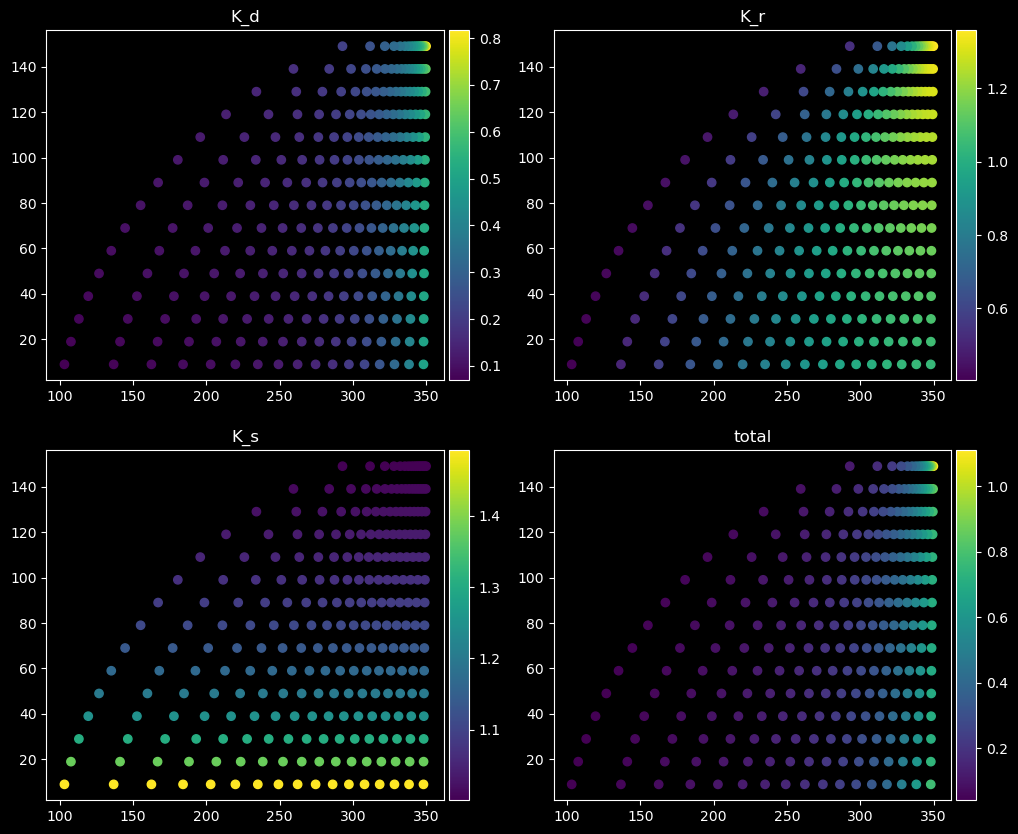

In [17]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, axes = plt.subplots(ncols=2,nrows=2,figsize=(12,10))
for k_coef, ax in zip(['K_d','K_r','K_s','total'], axes.reshape(-1)):
    cbar = ax.scatter(
        y0-y_values,x0-np.repeat(np.arange(1,x0,dx).reshape(1,-1),len(dirs),axis=0).reshape(-1),
        c=coefs[k_coef].values.reshape(-1) if k_coef!='total' else \
            (coefs.K_d*coefs.K_r*coefs.K_s).values.reshape(-1),
        # s = 5 if k_coef!='total' else 100, 
        # marker = '.' if k_coef!='total' else 's'
    )
    divider = make_axes_locatable(ax)
    ax1 = divider.append_axes("right", size="5%", pad=0.05) 
    fig.colorbar(cbar,cax=ax1)
    ax.set_title(k_coef)
plt.show()

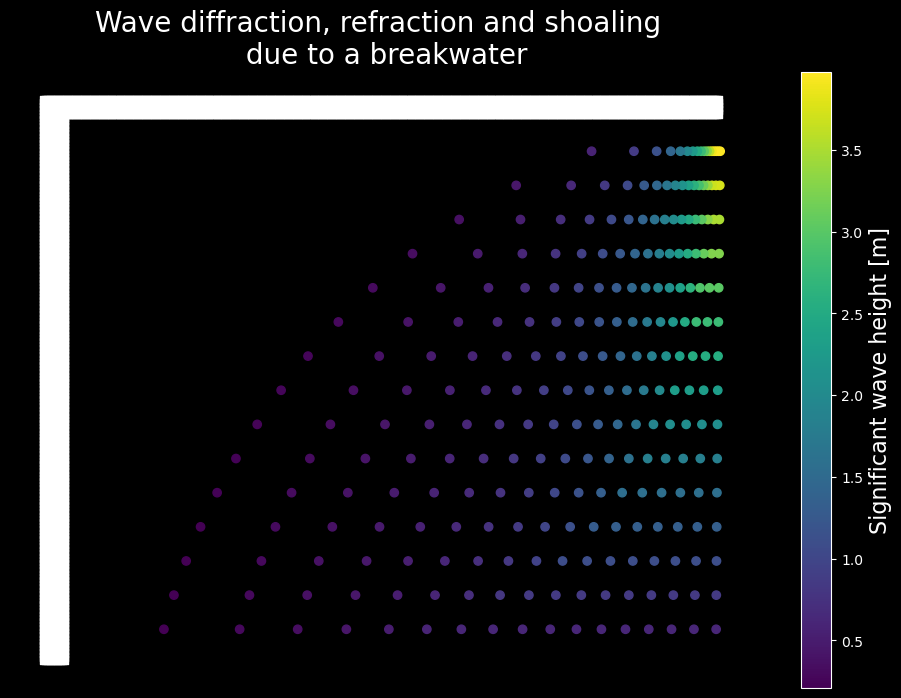

In [45]:
fig, ax = plt.subplots(figsize=(12,8))
col = ax.scatter(
    y0-y_values,x0-np.repeat(np.arange(1,x0,dx).reshape(1,-1),len(dirs),axis=0).reshape(-1),
    c=h_values_mat.reshape(-1),
    # s = 5 if k_coef!='total' else 100, 
    # marker = '.' if k_coef!='total' else 's'
)
ax.scatter(np.repeat(np.arange(50,60).reshape(1,-1),160,axis=0).reshape(-1),
           np.repeat(np.arange(160),10),
           c='white',marker='s')
ax.scatter(np.repeat(np.arange(50,350).reshape(1,-1),5,axis=0).reshape(-1),
           np.repeat(np.arange(160,165),300),
           c='white',marker='s')
cbar = fig.colorbar(col)
cbar.set_label('Significant wave height [m]',fontsize=16)
ax.set_title('Wave diffraction, refraction and shoaling \n due to a breakwater',fontsize=20)
ax.axis('off')
plt.show()